## Load Data

In [5]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pylab as plt
import sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
import xgboost
import shap
import pickle

In [6]:
#load data and replace nulls
df = pd.read_csv('Startup Data.csv')
df = df.replace('NaN', np.nan) 

#row 124 and 832 are repeats of the same data point
df.iloc[124] == df.iloc[832]
df = df.drop(832)

In [7]:
#check for unique id columns that can be ignored
print(df['Unnamed: 0'].value_counts().shape == df['Unnamed: 0'].shape)
print(df['id'].value_counts().shape == df['id'].shape)
print(df['name'].value_counts().shape == df['name'].shape)
print(df['object_id'].value_counts().shape == df['object_id'].shape)

#state code is repeated twice with one mismatched state name
print((df['state_code.1'] == df['state_code']).value_counts())

del df['Unnamed: 0']
del df['id']
del df['name']
del df['object_id']
del df['state_code.1']
del df['labels']

True
True
True
True
True     921
False      1
dtype: int64


In [8]:
df.head()

,state_code,latitude,longitude,zip_code,city,Unnamed: 6,founded_at,closed_at,first_funding_at,last_funding_at,...,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,CA,42.358880,-71.056820,92101,San Diego,NaN,1/1/2007,NaN,4/1/2009,1/1/2010,...,1,0,1,0,0,0,0,1.0000,0,acquired
1,CA,37.238916,-121.973718,95032,Los Gatos,NaN,1/1/2000,NaN,2/14/2005,12/28/2009,...,0,1,0,0,1,1,1,4.7500,1,acquired
2,CA,32.901049,-117.192656,92121,San Diego,San Diego CA 92121,3/18/2009,NaN,3/30/2010,3/30/2010,...,0,0,0,1,0,0,0,4.0000,1,acquired
3,CA,37.320309,-122.050040,95014,Cupertino,Cupertino CA 95014,1/1/2002,NaN,2/17/2005,4/25/2007,...,0,0,0,0,1,1,1,3.3333,1,acquired
4,CA,37.779281,-122.419236,94105,San Francisco,San Francisco CA 94105,8/1/2010,10/1/2012,8/1/2010,4/1/2012,...,0,1,1,0,0,0,0,1.0000,1,closed


In [9]:
df.shape

(922, 43)

## EDA

In [10]:
#histograms/bar charts of all features
columns = df.columns
for col in columns:
    if col in ss_ftrs:
        print(df[col].describe())
        df[col].plot.hist()
        plt.xlabel(col)
        plt.ylabel('count')
        plt.show()

NameError: name 'ss_ftrs' is not defined

In [11]:
#bar plots

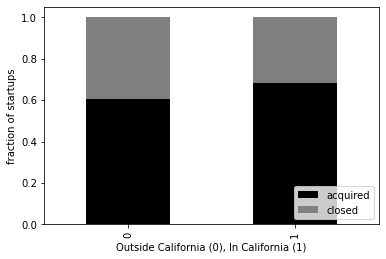

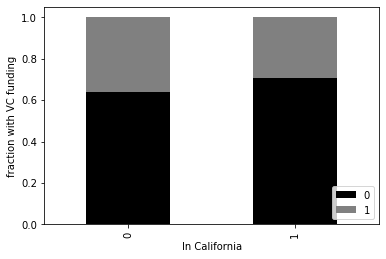

In [12]:
#comparing how well california startups did relative to the rest of the country
count_matrix = df.groupby(['is_CA', 'status']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True, color = ['k', 'grey'])
plt.xlabel('Outside California (0), In California (1)')
plt.ylabel('fraction of startups')
plt.legend(loc=4)
plt.show()

count_matrix = df.groupby(['is_CA', 'has_VC']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True, color = ['k', 'grey'])
plt.xlabel('In California')
plt.ylabel('fraction with VC funding')
plt.legend(loc=4)
plt.show()

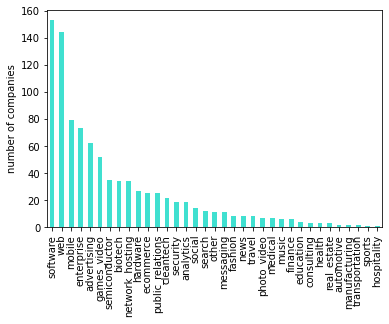

In [13]:
#histogram of the industries
df['category_code'].value_counts().plot.bar(color = 'turquoise')
plt.ylabel('number of companies')
plt.show()

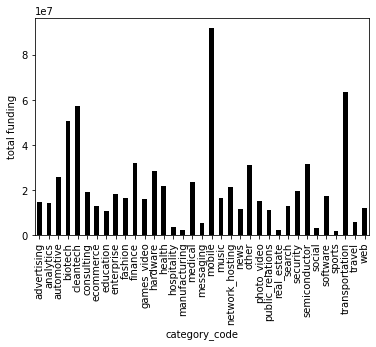

In [14]:
#plot showing industry type against total funding amount in usd
df.groupby('category_code', as_index=True)['funding_total_usd'].mean().plot.bar(color = 'k')
plt.ylabel('total funding')
plt.show()

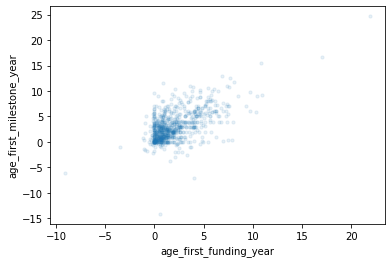

In [15]:
#comparing age of first funding year and age at first milestone shows a high concentration near (0,0)
#this is likely due to many companies who do not recieve any funding
#it is interesting to note the few outliers that were funded much later in their lives
df.plot.scatter('age_first_funding_year', 'age_first_milestone_year', s=10, alpha=.1)
plt.show()

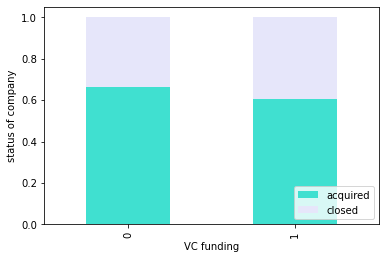

In [16]:
#funding vs status
count_matrix = df.groupby(['has_VC', 'status']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True, color = ['turquoise', 'lavender'])
plt.ylabel('status of company')
plt.xlabel('VC funding')
plt.legend(loc=4)
plt.show()

In [17]:
df.groupby(['has_VC', 'status']).size().unstack()

status,acquired,closed
has_VC,,
0,414,208
1,182,118


## Missing Data

In [18]:
perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
print('data types of the features with missing values:')
print(df[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)
frac_missing = sum(df.isnull().sum(axis=1)!=0)/df.shape[0]
print('fraction of points with missing values:',frac_missing)

fraction of missing values in features:
Unnamed: 6                  0.533623
closed_at                   0.636659
age_first_milestone_year    0.164859
age_last_milestone_year     0.164859
dtype: float64
data types of the features with missing values:
Unnamed: 6                   object
closed_at                    object
age_first_milestone_year    float64
age_last_milestone_year     float64
dtype: object
fraction of points with missing values: 0.8698481561822126


In [19]:
#categorical missing values new category 'missing'
df["closed_at"] = df["closed_at"].replace(np.nan, "missing")
df["Unnamed: 6"] = df["Unnamed: 6"].replace(np.nan, "missing")

In [20]:
#continuous missing values
print(df[['age_first_milestone_year','age_last_milestone_year']].head())

imputer = SimpleImputer(missing_values= np.nan, strategy='mean')

df[['age_first_milestone_year','age_last_milestone_year']] = imputer.fit_transform(np.array(df[['age_first_milestone_year','age_last_milestone_year']]))

   age_first_milestone_year  age_last_milestone_year
0                    4.6685                   6.7041
1                    7.0055                   7.0055
2                    1.4575                   2.2055
3                    6.0027                   6.0027
4                    0.0384                   0.0384


In [21]:
perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
print('data types of the features with missing values:')
print(df[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)
frac_missing = sum(df.isnull().sum(axis=1)!=0)/df.shape[0]
print('fraction of points with missing values:',frac_missing)

fraction of missing values in features:
Series([], dtype: float64)
data types of the features with missing values:
Series([], dtype: object)
fraction of points with missing values: 0.0


## Preprocessing

In [22]:
#all remaining features split between categorical/continuous/dates to be transformed to continuous
#categorical features split further between ordinal scaler and one hot encoder

cat_ftrs = ['state_code', 'zip_code', 'city', 'Unnamed: 6', 'is_CA','is_NY','is_MA', 
        'is_TX', 'is_otherstate', 'category_code', 'is_software', 'is_web','is_mobile', 
        'is_enterprise','is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 
        'is_consulting', 'is_othercategory', 'avg_participants', 'has_VC', 'has_angel', 'has_roundA', 
        'has_roundB', 'has_roundC', 'has_roundD','is_top500', 'milestones']

ss_ftrs = ['latitude', 'longitude', 'age_first_funding_year', 'age_last_funding_year', 
            'age_first_milestone_year', 'age_last_milestone_year', 'relationships', 
            'funding_rounds', 'avg_participants', 'funding_total_usd']

dates = ['founded_at', 'closed_at', 'first_funding_at', 'last_funding_at']


In [23]:
#set X and y matrices
y = df['status']
X = df.loc[:, df.columns != 'status']

In [24]:
#transform dates into continuous variables using epoch time
for date_col in dates:
    index = 0
    for date_raw in X[date_col]:
        if date_raw != 'missing':
            date = (date_raw).split("/")
            date = [int(x) for x in date]
            X[date_col].iloc[index] = datetime.datetime(date[2], date[0], date[1]).timestamp()
        index += 1


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [25]:
X['closed_at'] = X['closed_at'].replace('missing', np.nan)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [26]:
imputer = SimpleImputer(missing_values= np.nan, strategy='mean')

X[['closed_at']] = imputer.fit_transform(np.array(X[['closed_at']]))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [27]:
#one-hot encoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

#standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

#add dates to continuous features
ss_ftrs.extend(dates)

#group transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ss_ftrs),
        ('cat', categorical_transformer, cat_ftrs)])

In [28]:
#data split
random_state = 7

#separate out training set
X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,random_state=random_state)

#split out validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state=random_state)

In [29]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

#feature_names = cat_ftrs
#feature_names.extend(ss_ftrs)


# fit_transform the training set
X_train_prep = preprocessor.fit_transform(X_train)

feature_names = preprocessor.transformers_[0][-1] + \
                list(preprocessor.named_transformers_['cat'][1].get_feature_names(cat_ftrs))

df_train = pd.DataFrame(data=X_train_prep,columns=feature_names)
print(X_train_prep.shape)

# transform the CV
X_val_prep = preprocessor.transform(X_val)
df_val = pd.DataFrame(data=X_val_prep,columns = feature_names)
print(X_val_prep.shape)

# transform the test
X_test_prep = preprocessor.transform(X_test)
df_test = pd.DataFrame(data=X_test_prep,columns = feature_names)
print(X_test_prep.shape)

(553, 772)
(184, 772)
(185, 772)


## Pipeline

In [30]:
def ML_pipeline(X, y, preprocessor, ML_algo, param_grid):
    test_scores = []
    best_models = []
    
    for i in range(0,10):
        # split data to other/test 80/20, and the use KFold with 4 folds
        X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = 7*i)
        kf = KFold(n_splits=4,shuffle=True,random_state=7*i)
        # preprocess the data
        pipe = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', ML_algo)])
        #label encoder for target variable
        le = LabelEncoder()
        y_other = le.fit_transform(y_other)
        y_test = le.transform(y_test)
        # loop through the hyperparameter combinations or use GridSearchCV
        grid = GridSearchCV(pipe, param_grid=param_grid,scoring = make_scorer(accuracy_score),
                        cv=kf, return_train_score = True)
        # for each combination, calculate the train and validation scores using the evaluation metric
        grid.fit(X_other, y_other)
        # find which hyperparameter combination gives the best validation score
        best_combination = grid.best_params_
        # calculate the test score
        y_pred = grid.predict(X_test)
        # append the test score and the best model to the lists
        test_scores.append(accuracy_score(y_test, y_pred))
        best_models.append(grid.best_estimator_)
    return grid, best_models, test_scores

## Models

In [31]:
count1,count2=0,0
for x in y:
    if x == 'acquired':
        count1+=1
    else:
        count2+=1
baseline_accuracy = count1/(count1+count2)
print("baseline accuracy score: ", baseline_accuracy)

baseline accuracy score:  0.6464208242950108


In [32]:
SVC = SVC()
param_grid = {'regressor__C': np.logspace(-3,4,num=8),'regressor__gamma': np.logspace(-3,4,num=8)}
svc_grid, svc_models, svc_scores = ML_pipeline(X, y, preprocessor, SVC, param_grid)

print(svc_scores)
print()
print("SVC: mean -", np.mean(svc_scores), ", standard deviation -", np.std(svc_scores))

[0.8378378378378378, 0.827027027027027, 0.8702702702702703, 0.8324324324324325, 0.8162162162162162, 0.8216216216216217, 0.8648648648648649, 0.8864864864864865, 0.8648648648648649, 0.8432432432432433]

SVC: mean - 0.8464864864864865 , standard deviation - 0.022443826477866708


In [33]:
print(svc_grid.best_params_)
print()
print("best test score: ", svc_scores[np.argmax(svc_scores)])
print()
print("num standard deviations from baseline: ", 
      (svc_scores[np.argmax(svc_scores)] - baseline_accuracy)/np.std(svc_scores))

{'regressor__C': 10.0, 'regressor__gamma': 0.01}

best test score:  0.8864864864864865

num standard deviations from baseline:  10.696289352807991


In [34]:
file = open('results/grid.save', 'wb')
pickle.dump((grid,X_test,y_test),file)
file.close()

FileNotFoundError: [Errno 2] No such file or directory: 'results/grid.save'

In [ ]:
KNC = KNeighborsClassifier()
param_grid = {'regressor__n_neighbors': [1, 3, 5, 8, 20, 30, 50]}

knc_grid, knc_models, knc_scores = ML_pipeline(X,y,preprocessor,KNC,param_grid)
print(knc_scores)
print()
print("KNeighbors: mean -", np.mean(knc_scores), ", standard deviation -", np.std(knc_scores))

In [ ]:
print(knc_grid.best_params_)
print()
print("best test score: ", knc_scores[np.argmax(knc_scores)])
print()
print("num standard deviations from baseline: ", 
      (knc_scores[np.argmax(knc_scores)] - baseline_accuracy)/np.std(knc_scores))

In [ ]:
RFC = RandomForestClassifier()
param_grid = {
              'regressor__max_depth': [1, 3, 10, 30, 100], # the max_depth should be smaller or equal than the number of features roughly
              'regressor__max_features': [0.5,0.75,1.0] # linearly spaced between 0.5 and 1
              } 
rf_grid, rf_models, rf_scores = ML_pipeline(X,y,preprocessor,RFC,param_grid)
print(rf_scores)
print()
print("random forest: mean -", np.mean(rf_scores), ", standard deviation -", np.std(rf_scores))

In [ ]:
#standardize coeffients and look at features
LR = LogisticRegression(penalty='l2', max_iter = 10000)
param_grid = {'regressor__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

lr_grid, lr_models, lr_scores = ML_pipeline(X,y,preprocessor,LR,param_grid)
print(lr_scores)
print()
print("logistic regression: mean -", np.mean(lr_scores), ", standard deviation -", np.std(lr_scores))

In [ ]:
print(lr_grid.best_params_)
print()
print("best test score: ", lr_scores[np.argmax(lr_scores)])
print()
print("num standard deviations from baseline: ", 
      (lr_scores[np.argmax(lr_scores)] - baseline_accuracy)/np.std(lr_scores))

In [ ]:
XGB = xgboost.XGBClassifier()
param_grid = {"regressor__learning_rate": [0.03],
              "regressor__n_estimators": [10000],
              "regressor__seed": [0],
              "regressor__missing": [np.nan], 
              "regressor__colsample_bytree": [0.9],              
              "regressor__subsample": [0.66]}
xgb_grid, xgb_models, xgb_scores = ML_pipeline(X,y,preprocessor,XGB,param_grid)
print(xgb_scores)
print()
print("xgboost: mean -", np.mean(xgb_scores), ", standard deviation -", np.std(xgb_scores))

## Feature Importance

In [ ]:
result = permutation_importance(SVC.fit(df_train, y_train), df_test, y_test, n_repeats = 10, random_state = 0,
                                scoring = 'accuracy')

In [ ]:
#feature importance
sorted_indcs = result.importances_mean.argsort()[:-11:-1]

for i in sorted_indcs:
    if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
        print(f"{feature_names[i]:<8} "
              f"{result.importances_mean[i]:.3f}"
              f" +/- {result.importances_std[i]:.3f}")

In [ ]:
#shap summary plot logistic regression
explainer = shap.LinearExplainer(LR, df_train, feature_dependence="independent")
shap_values = explainer.shap_values(df_test)
shap.summary_plot(shap_values, df_test, feature_names=feature_names, max_display=10)

In [ ]:
#point 0 - successful company
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], df_test.iloc[0,:])

In [ ]:
#point 4 - failed company
shap.force_plot(explainer.expected_value, shap_values[4,:], df_test.iloc[4,:])

In [ ]:
mymodel = XGB.fit(df_train, y_train)
mybooster = mymodel.get_booster()    
model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun
explainer = shap.TreeExplainer(mybooster)
shap_values = explainer.shap_values(df_test)
shap.summary_plot(shap_values, df_test, max_display = 10)

In [ ]:
plt.boxplot([svc_scores, knc_scores, lr_scores])
plt.axhline(y=baseline_accuracy, label = "baseline")
plt.ylabel('accuracy score')
labels = ('support vector', 'k-neighbors', 'logistic regression')
plt.xticks(np.arange(len(labels))+1,labels)
plt.title('test scores')
plt.show()